## Glyph error analysis

The `GlyphErrorBenchmark.cpp` creates a number of different rendered glyph textures into `src/rendered_glyph_textures` with different parameters (different code points, scales, original sizes etc.)

In this notebook I categorize these images and calculate the errors in each of them to figure out which method performs the best

In [121]:
# libraries
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from PIL import Image
from PIL import ImageOps

## Importing glyph images

In [122]:
# type definitions
class GlyphType(Enum):
    Original = 0
    Bitmap = 1
    SdfFromBitmap = 2
    SdfFromVector = 3
    Msdf = 4
    MsdfOriginal = 5

class Glyph:
    def __init__(self, glyphType, code_point, original_size, scale, img):
        self.glyph_type = glyphType
        self.code_point = code_point
        self.original_size = original_size
        self.scale = scale
        self.img = img
        self.error = None

    def __str__(self):
        return self.glyph_type.name + ' ' + self.code_point + ' ' + str(self.original_size) + ' ' + str(self.scale)

    def isComparable(self, other):
        return self.scale == other.scale and self.original_size == other.original_size and self.code_point == other.code_point

In [123]:
# load and filter all the glyphs
directory = '../src/rendered_glyph_textures'

truth_glyphs = []
glyphs = []

for filename in os.listdir(directory):
    if filename.endswith('.png'):
        info = filename.split('_')
        glyph_type = GlyphType(int(info[0][0]))
        code_point = info[1]
        original_size = int(info[2])
        scale = float(info[3])
        img = Image.open(os.path.join(directory, filename)).convert('L')
        img.load()
        
        # print('Found glyph: ' + str(glyph_type) + ' ' + str(code_point) + ' ' + str(original_size) + ' ' + str(scale) + ' image size: ' + str(img.size))

        if glyph_type == GlyphType.Original:
            truth_glyphs.append(Glyph(glyph_type, code_point, original_size, scale, img))
        else:
            glyphs.append(Glyph(glyph_type, code_point, original_size, scale, img))
print()
print('\033[96m' + 'Number of glyphs: ' + str(len(glyphs)))
print('\033[96m' + 'Number of different code points ' + str(len(set([g.code_point for g in glyphs]))))
print('\033[96m' + 'Number of glyph types: ' + str(len(set([g.glyph_type for g in glyphs]))))
print('\033[96m' + 'Number of truth glyphs: ' + str(len(truth_glyphs)))


Number of glyphs: 1008
Number of different code points 7
Number of glyph types: 4
Number of truth glyphs: 252


## Calculating glyph errors

In [150]:
# helper functions

def getGlyph(glyphType, code_point, original_size, scale):
    for glyph in glyphs:
        if glyph.glyph_type == glyphType and glyph.code_point == code_point and glyph.original_size == original_size and glyph.scale == scale:
            return glyph
    return None

def findTruthForGlyph(glyph):
    for truth in truth_glyphs:
        if truth.isComparable(glyph):
            return truth
    return None

def sign(x):
    if x > 0:
        return 1
    if x < 0:
        return -1
    return 0

# todo: Should I just pad the original glyph on the center
# of a glyph instead of modifying the other ones????

# rendered glyphs might have different sizes so we want to 
# add some zero pixels so they are the same size as the truth
# we need to be careful to keep them in the center
def resizeGlyph(glyph_image, new_width, new_height):
    delta_x = new_width - glyph_image.size[0]
    delta_y = new_height - glyph_image.size[1]

    # crop if needed
    if delta_x < 0:
        x_start = abs(delta_x) // 2
        glyph_image = glyph_image.crop((x_start, 0, x_start + new_width, glyph_image.size[1]))
    if delta_y < 0:
        y_start = abs(delta_y) // 2
        glyph_image = glyph_image.crop((0, y_start, glyph_image.size[0], y_start + new_height))

    # pad if needed
    if delta_x > 0:
        padding_x = delta_x // 2
        ob1 = (delta_x % 2) * sign(delta_x)
        glyph_image = ImageOps.expand(glyph_image, (padding_x + ob1, 0, padding_x, 0))
    if delta_y > 0:
        padding_y = delta_y // 2
        ob1 = (delta_y % 2) * sign(delta_y) 
        glyph_image = ImageOps.expand(glyph_image, (0, padding_y + ob1, 0, padding_y))
    
    return glyph_image

In [125]:
# a and b are tuples of (r, g, b, a)
def errorFunction(a, b):
    return abs(a - b)

def calculateGlyphError(truth, glyph):
    if not truth.isComparable(glyph):
        raise Exception('Glyphs are not comparable: ' + str(truth) + ' ' + str(glyph))
    
    if truth.img.size != glyph.img.size:
        raise Exception('Glyphs ' + str(truth) + ' ' + str(glyph) + ' have different sizes: ' + str(truth.img.size) + ' ' + str(glyph.img.size))

    # calculate error pixel by pixel
    error = 0
    for y in range(0, truth.img.height):
        for x in range(0, truth.img.width):
            truth_pixel = truth.img.getpixel((x, y))
            glyph_pixel = glyph.img.getpixel((x, y))
            error += errorFunction(truth_pixel, glyph_pixel)

    # normalize error
    error = error / (truth.img.width * truth.img.height)
    return error;


# calculate all the glyph errors
for glyph in glyphs:
    truth = findTruthForGlyph(glyph)
    glyph.img = resizeGlyph(glyph.img, truth.img.size[0], truth.img.size[1])
    error = calculateGlyphError(truth, glyph)
    glyph.error = error

### Organize the glyphs

In [135]:
glyph_bucket = {}
glyph_original_sizes = set([glyph.original_size for glyph in glyphs])
glyph_original_sizes = sorted(glyph_original_sizes, reverse=False)

# put glyphs in buckets by: glyph_type, code_point, original_size and order by scale ascending
for glyph in glyphs:
    key = (glyph.glyph_type, glyph.code_point, glyph.original_size)
    if key not in glyph_bucket:
        glyph_bucket[key] = []
    glyph_bucket[key].append(glyph)

for key in glyph_bucket:
    glyph_bucket[key] = sorted(glyph_bucket[key], key=lambda x: x.scale)

def getGlyphsByType(glyph_type):
    return [glyph for key, glyphs in glyph_bucket.items() if key[0] == glyph_type for glyph in glyphs]

def getGlyphsByTypeAndSize(glyph_type, original_size):
    return [glyph for key, glyphs in glyph_bucket.items() if key[0] == glyph_type and key[2] == original_size for glyph in glyphs]

## Average error per glyph rendering type

In [127]:
avg_glyph_type_error = {}
glyph_type_count = {}

for glyph in glyphs:
    if glyph.glyph_type in avg_glyph_type_error:
        avg_glyph_type_error[glyph.glyph_type] += glyph.error
        glyph_type_count[glyph.glyph_type] += 1
    else:
        avg_glyph_type_error[glyph.glyph_type] = glyph.error
        glyph_type_count[glyph.glyph_type] = 1

for glyph_type in avg_glyph_type_error:
    avg_glyph_type_error[glyph_type] = avg_glyph_type_error[glyph_type] / glyph_type_count[glyph_type]

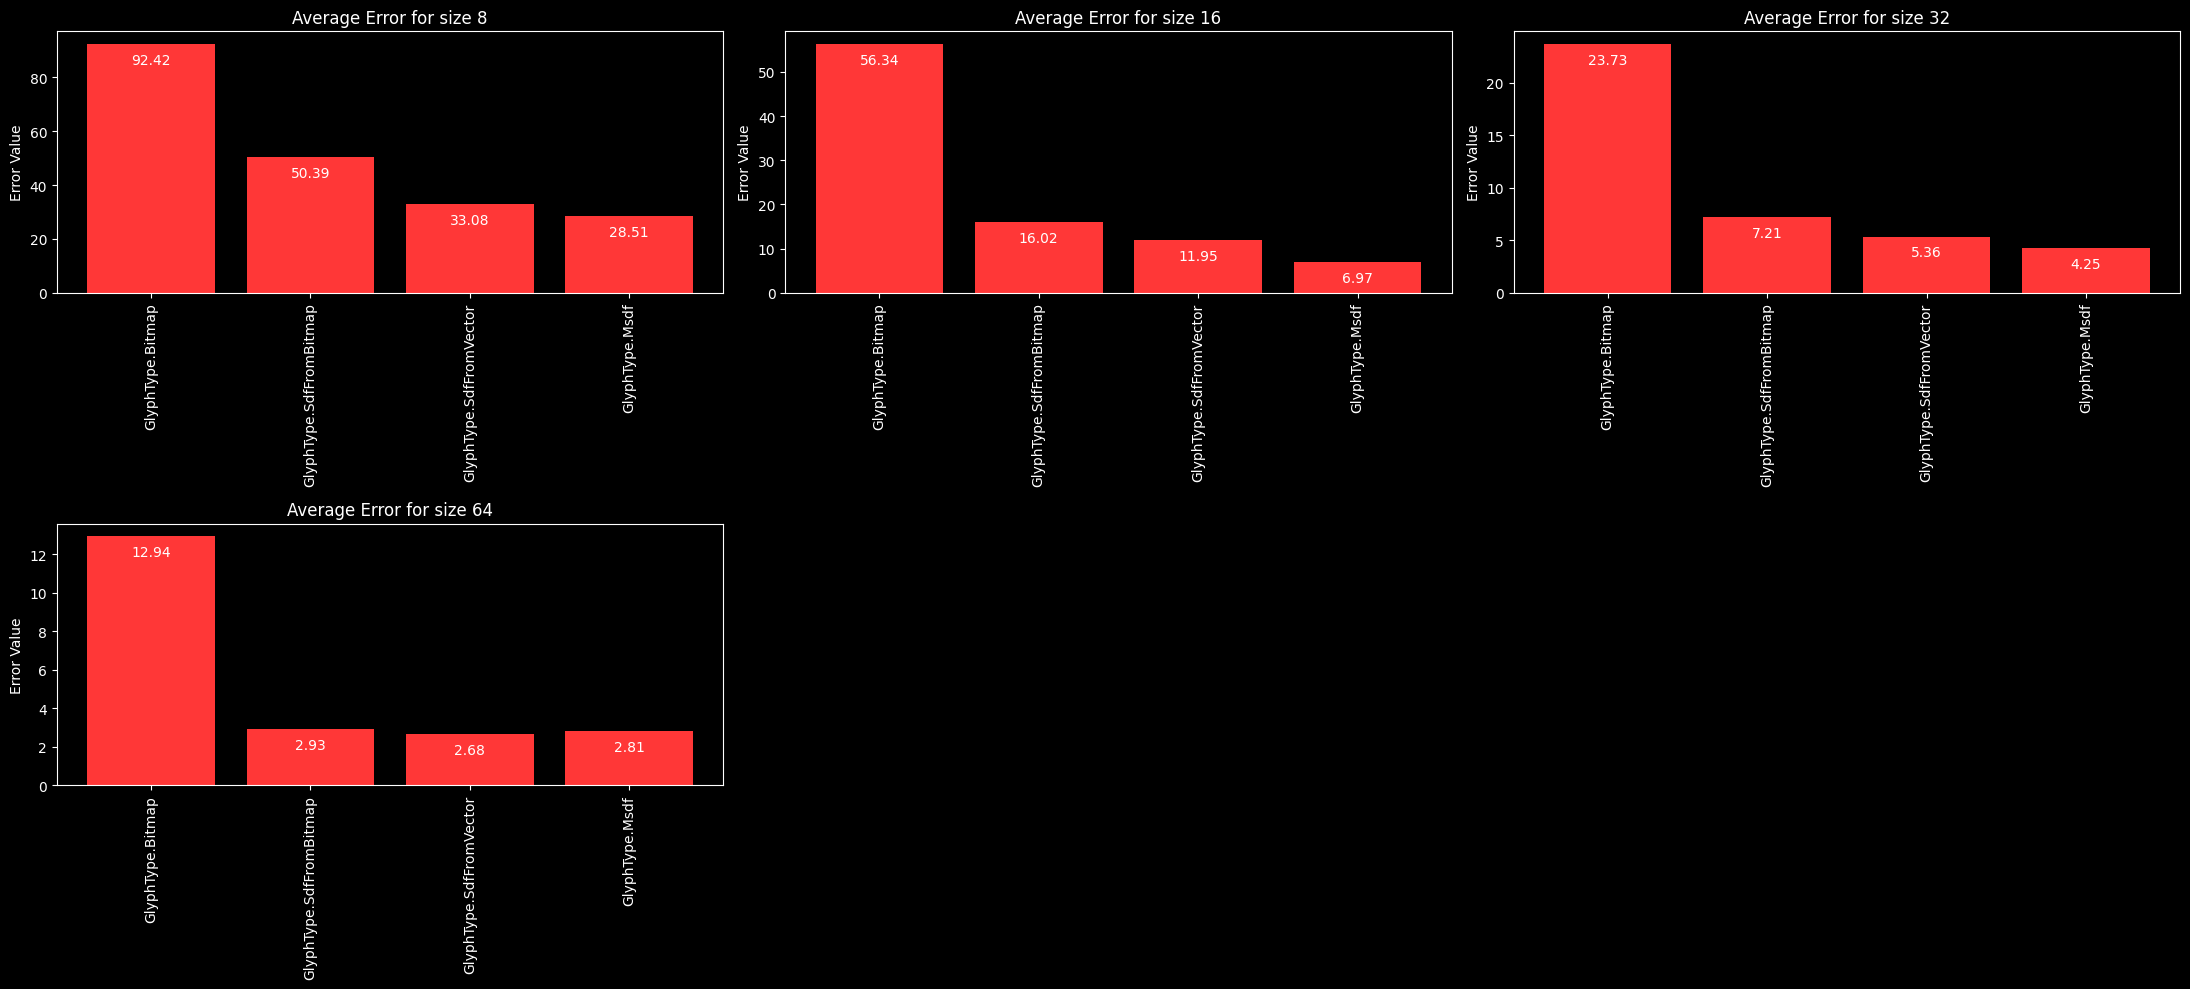

In [165]:
num_sizes = len(glyph_original_sizes)
num_rows = math.ceil(num_sizes / 3)

fig, axs = plt.subplots(num_rows, 3, figsize=(22, 5*num_rows))

avg_glyph_error = {}
glyph_count = {}

for i, size in enumerate(glyph_original_sizes):
    row = i // 3
    col = i % 3

    avg_glyph_type_error = {}
    glyph_type_count = {}

    for glyph_type in GlyphType:
        if glyph_type == GlyphType.Original:
            continue
        glyphs_by_type = getGlyphsByTypeAndSize(glyph_type, size)

        for g in glyphs_by_type:
            if g.glyph_type in avg_glyph_type_error:
                avg_glyph_type_error[g.glyph_type] += g.error
                glyph_type_count[g.glyph_type] += 1
                avg_glyph_error[g.glyph_type] += g.error
                glyph_count[g.glyph_type] += 1
            else:
                avg_glyph_type_error[g.glyph_type] = g.error
                glyph_type_count[g.glyph_type] = 1
                avg_glyph_error[g.glyph_type] = g.error
                glyph_count[g.glyph_type] = 1

    for glyph_type in avg_glyph_type_error:
        avg_glyph_type_error[glyph_type] = avg_glyph_type_error[glyph_type] / glyph_type_count[glyph_type]

    x_axis = avg_glyph_type_error.keys()
    y_axis = avg_glyph_type_error.values()

    axs[row, col].bar([str(glyph) for glyph in x_axis], y_axis, color='#FF3737')

    axs[row, col].set_title('Average Error for size ' + str(size))
    axs[row, col].set_ylabel('Error Value')
    axs[row, col].tick_params(axis='x', rotation=90)

    # Add precise values at each bar
    for j, value in enumerate(y_axis):
        axs[row, col].text(j, value - 0.08 * max(y_axis), f"{value:.2f}", ha='center')

# Hide any unused subplots
for i in range(num_sizes, num_rows*3):
    axs[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

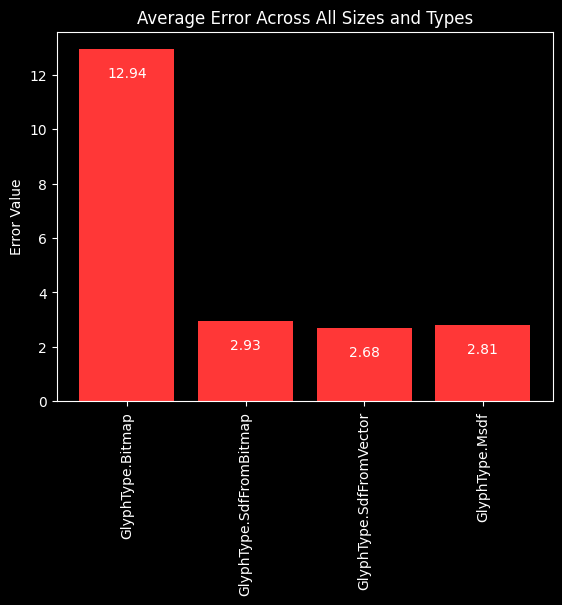

In [166]:
# plot averaged errors
for glyph_type in avg_glyph_error:
    avg_glyph_error[glyph_type] = avg_glyph_error[glyph_type] / glyph_count[glyph_type]

x_axis = avg_glyph_error.keys()
y_axis = avg_glyph_error.values()

plt.bar([str(glyph) for glyph in x_axis], y_axis, color='#FF3737')
plt.title('Average Error Across All Sizes and Types')
plt.ylabel('Error Value')
plt.tick_params(axis='x', rotation=90)

# Add precise values at each bar
for j, value in enumerate(y_axis):
    plt.text(j, value - 0.08 * max(y_axis), f"{value:.2f}", ha='center')

## Glyph error as a function of scale

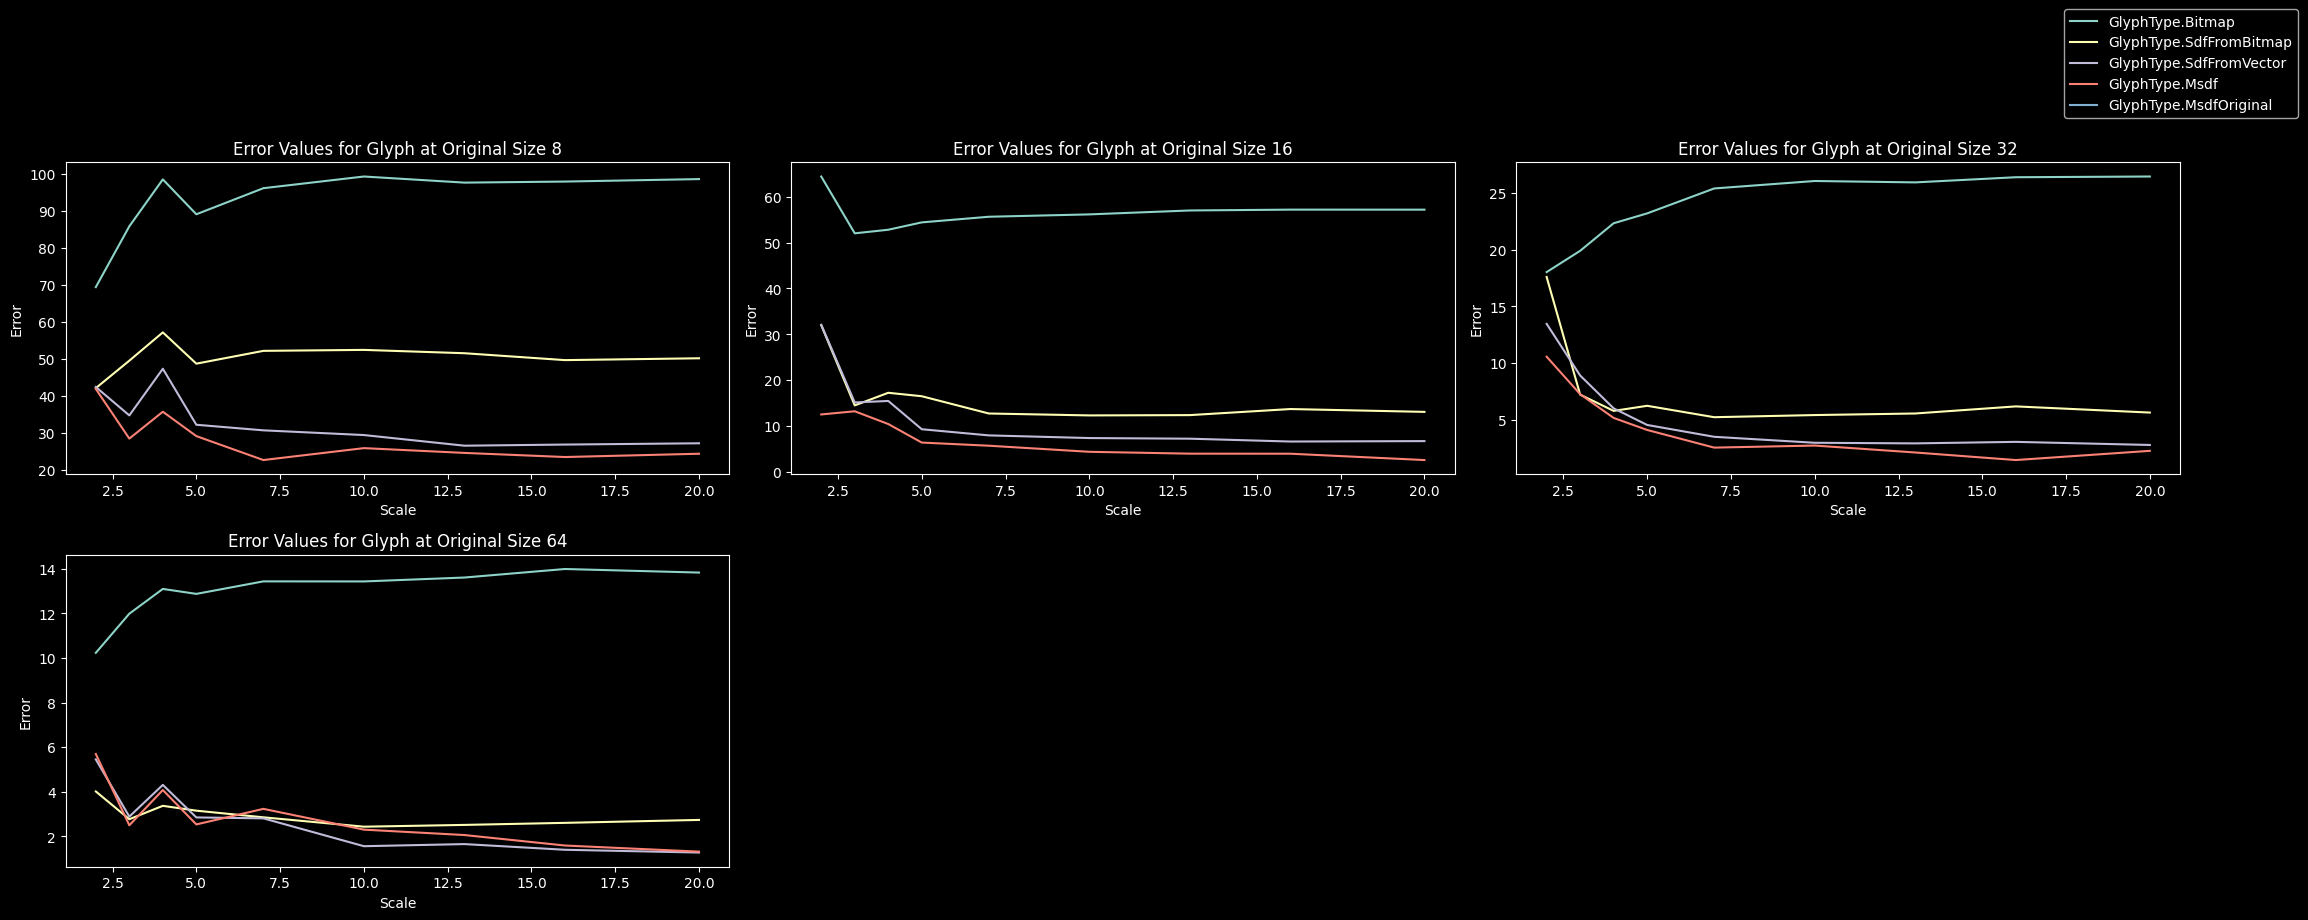

In [149]:
num_sizes = len(glyph_original_sizes)
num_rows = math.ceil(num_sizes / 3)

fig, axs = plt.subplots(num_rows, 3, figsize=(22, 4*num_rows))
labels = [str(glyph_type) for glyph_type in GlyphType if glyph_type != GlyphType.Original]

for i, size in enumerate(glyph_original_sizes):
    row = i // 3
    col = i % 3

    for glyph_type in GlyphType:
        if glyph_type == GlyphType.Original:
            continue
        glyphs_by_type = getGlyphsByTypeAndSize(glyph_type, size)
        errors_by_scale = {}
        scales_count = {}

        for glyph in glyphs_by_type:
            if glyph.scale in errors_by_scale:
                errors_by_scale[glyph.scale] += glyph.error
                scales_count[glyph.scale] += 1
            else:
                errors_by_scale[glyph.scale] = glyph.error
                scales_count[glyph.scale] = 1

        for scale in errors_by_scale:
            errors_by_scale[scale] = errors_by_scale[scale] / scales_count[scale]

        x_axis = errors_by_scale.keys()
        y_axis = errors_by_scale.values()

        axs[row, col].plot(x_axis, y_axis, label=str(glyph_type))

    axs[row, col].set_title(f'Error Values for Glyph at Original Size {size}')
    axs[row, col].set_xlabel('Scale')
    axs[row, col].set_ylabel('Error')

# Create a single legend for all plots
fig.legend(labels, loc='lower right', bbox_to_anchor=(1.05, 1))

# Hide any unused subplots
for i in range(num_sizes, num_rows*3):
    axs[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

In [130]:
def showGlyphDiff(glyph):
    glyph_img = glyph.img
    truth_img = findTruthForGlyph(glyph).img

    truth_img = ImageOps.colorize(truth_img, black='black', white='lime')
    glyph_img = ImageOps.colorize(glyph_img, black='black', white='red')

    # convert glyph_img to RGBA
    glyph_img_rgba = np.array(glyph_img.convert('RGBA'))
    truth_img_rgba = np.array(truth_img.convert('RGBA'))

    # set alpha channel to 0 where pixel value is black 
    glyph_img_rgba[glyph_img_rgba[:, :, 0] == 0, 3] = 0
    truth_img_rgba[truth_img_rgba[:, :, 1] == 0, 3] = 0

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    background_color = '#000000'
    ax.set_facecolor(background_color)
    fig.patch.set_facecolor(background_color)
    ax.spines['bottom'].set_color(background_color)
    ax.spines['top'].set_color(background_color)
    ax.spines['right'].set_color(background_color)
    ax.spines['left'].set_color(background_color)

    # ax.set_xticks([])
    # ax.set_yticks([])

    ax.imshow(truth_img_rgba)
    ax.imshow(glyph_img_rgba, alpha=0.6)

    # show the plot
    plt.tight_layout()
    plt.show()

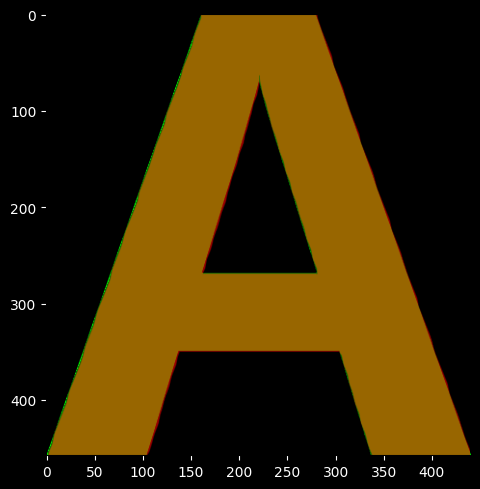

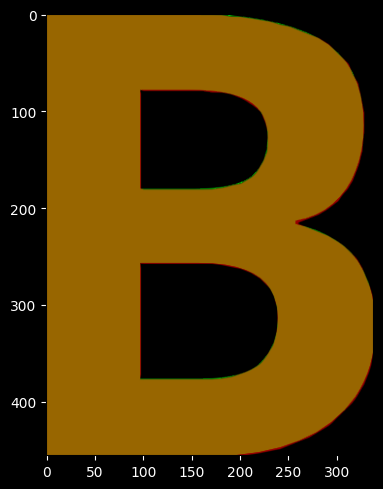

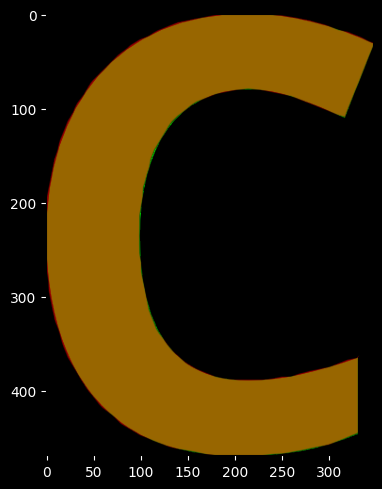

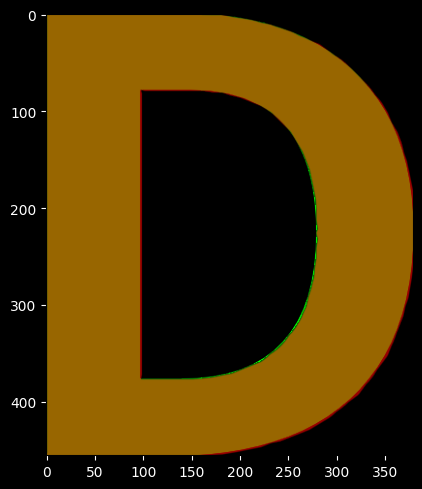

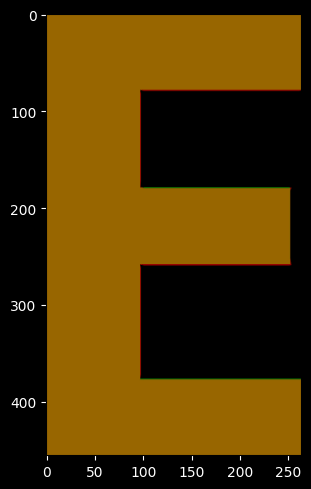

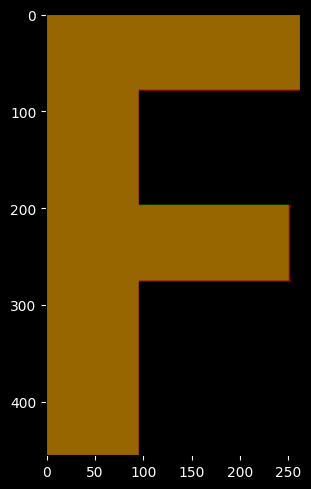

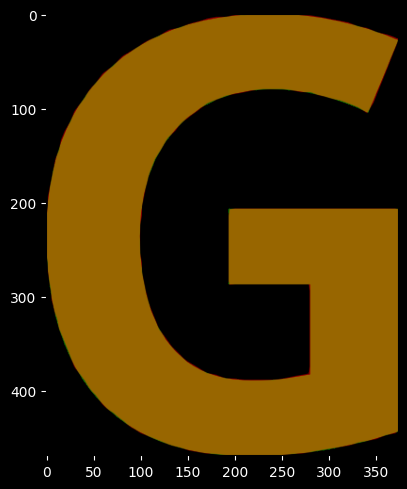

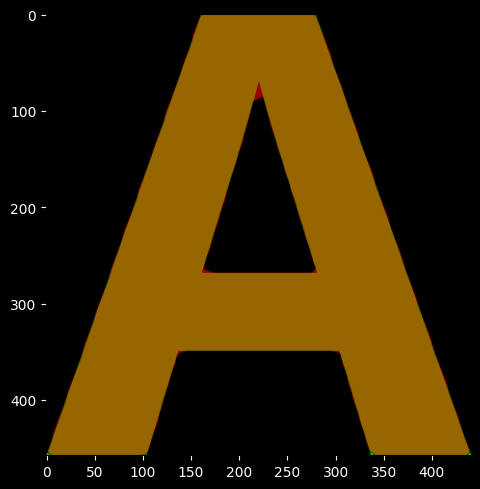

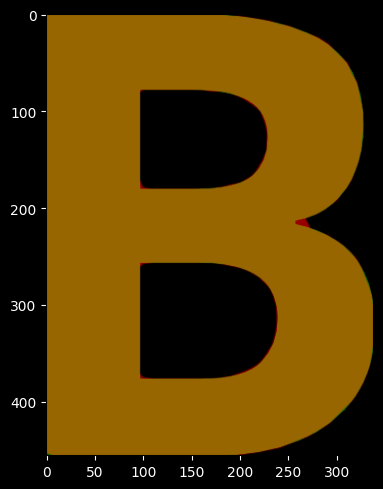

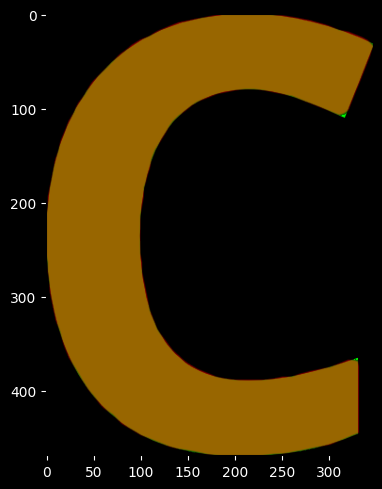

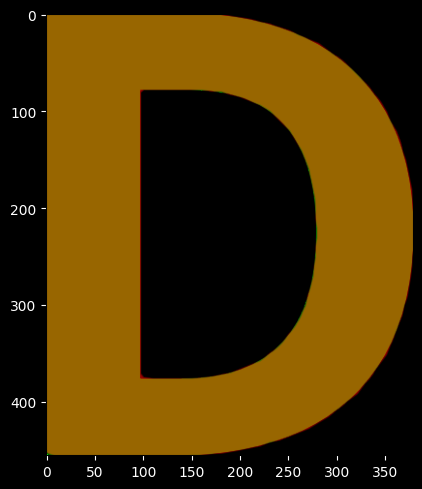

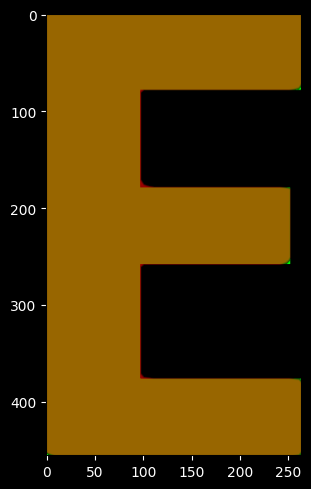

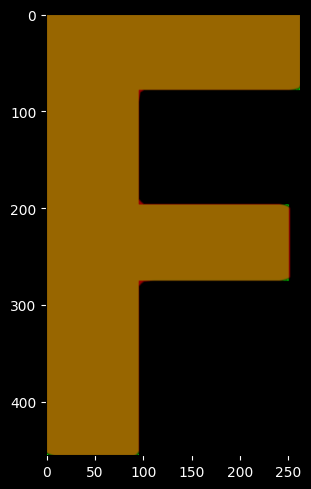

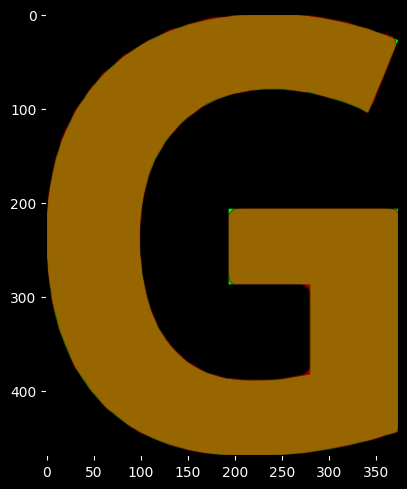

In [132]:
# code_points = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

# for c in code_points:
#     g = getGlyph(GlyphType.Msdf, c, 64, 10.0)
#     showGlyphDiff(g)

# for c in code_points:
#     g = getGlyph(GlyphType.SdfFromVector, c, 64, 10.0)
#     showGlyphDiff(g)